In [1]:
from argparse import Namespace

import pprint
import math
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

from google.cloud import bigquery

In [2]:
SQL = """
SELECT 
order_id,
customer_merchant_id,
product_id,
item_name,
DATE(order_time) as order_time
FROM `warung-support.dwh_access.fact_odoo_sales_order`, UNNEST(order_items)
WHERE order_status = 'sale'
AND DATE(order_time) BETWEEN "2021-01-01" AND "2021-03-31"
"""

client = bigquery.Client()
query_job = client.query(SQL).result()
df = query_job.to_dataframe()

In [3]:
df.head()

,order_id,customer_merchant_id,product_id,item_name,order_time
0,WPD-SO766299,WP31317113702,WPD-12249,[RSO001] Roma Slai Olai Selai Blueberry 24gr,2021-02-22
1,WPD-SO766299,WP31317113702,WPD-18161,[OIS004] Oishi Pillows Ubi 7gr,2021-02-22
2,WPD-SO766299,WP31317113702,WPD-18155,[NUT016] Nutrijell Pudding Susu Powder Strawbe...,2021-02-22
3,WPD-SO766299,WP31317113702,WPD-9260,[ZIN004] Zinc Shampo Refreshing Cool 12ml,2021-02-22
4,WPD-SO766299,WP31317113702,WPD-9143,[PEP001] Pepsodent Jumbo Merah Pencegah Gigi B...,2021-02-22


In [4]:
d_transaction = df.groupby(by=["order_id", "customer_merchant_id", "order_time"])["product_id"].apply(list).reset_index()

In [5]:
d_transaction.shape

(286650, 4)

In [6]:
d_transaction = d_transaction.sort_values(by=["customer_merchant_id", "order_time"]).copy()

In [7]:
d_transaction.customer_merchant_id.unique().shape

(46675,)

In [8]:
(d_transaction.customer_merchant_id.value_counts() == 1).sum()

14118

In [9]:
# filter merchant id that had more than n transactions
n_transaction = 4
merchant_id_selected = [id_ for id_, value in (d_transaction.customer_merchant_id.value_counts() > n_transaction).items() if value]

In [10]:
d_transaction2 = d_transaction[d_transaction.customer_merchant_id.isin(merchant_id_selected)].copy()

In [11]:
d_transaction3 = d_transaction2.groupby("customer_merchant_id").tail()

In [12]:
d_transaction3 = d_transaction3.sort_values(by=['order_time', 'customer_merchant_id'])

In [13]:
d_transaction4 = d_transaction3.groupby(
    'customer_merchant_id')['product_id'].apply(
    lambda products: list(itertools.chain.from_iterable(products))).reset_index()

In [14]:
product_ids = itertools.chain.from_iterable(d_transaction4.product_id.to_list())

In [15]:
product_ids = list(set(product_ids))

In [17]:
d_transaction4['product_idx'] = d_transaction4.product_id.apply(
    lambda items: [product_ids.index(item) for item in items])

In [18]:
d_transaction4['train'] = d_transaction4.product_idx.apply(lambda products: products[:-2])

In [19]:
d_transaction4['val'] = d_transaction4.product_idx.apply(lambda products: products[-2:-1])

In [20]:
d_transaction4['test'] = d_transaction4.product_idx.apply(lambda products: products[-1:])

In [35]:
def generate_negative_sample(product_idx):
    items = set(list(range(len(product_ids)))) - set(product_idx)
    return random.sample(items, 100)

In [36]:
d_transaction4['neg_sample'] = d_transaction4.product_idx.apply(generate_negative_sample)

In [37]:
d_transaction4.head()

,customer_merchant_id,product_id,product_idx,train,val,test,neg_sample,train_len
0,WP101400604,"[WPD-5003, WPD-4840, WPD-5525, WPD-5010, WPD-5...","[4505, 4408, 567, 5477, 3512, 3341, 3611, 2217...","[4505, 4408, 567, 5477, 3512, 3341, 3611, 2217...",[2892],[225],"[920, 4949, 1876, 2138, 3741, 911, 4105, 1659,...",81
1,WP102100601,"[WPD-12986, WPD-18171, WPD-9272, WPD-4876, WPD...","[2217, 2702, 4464, 1421, 623, 4159, 5019, 2177...","[2217, 2702, 4464, 1421, 623, 4159, 5019, 2177...",[2217],[2177],"[4689, 4619, 1668, 455, 5027, 5469, 2767, 4274...",10
2,WP102100602,"[WPD-15793, WPD-5512, WPD-13004, WPD-4995, WPD...","[616, 4306, 1240, 3570, 2664, 1444, 1421, 1534...","[616, 4306, 1240, 3570, 2664, 1444, 1421, 1534...",[4617],[5494],"[3172, 4739, 194, 5535, 4239, 1689, 4076, 4694...",68
3,WP102200601,"[WPD-13130, WPD-4803, WPD-5019, WPD-14292, WPD...","[1859, 1628, 799, 2191, 469, 2177, 1120, 484, ...","[1859, 1628, 799, 2191, 469, 2177, 1120, 484, ...",[1060],[469],"[4902, 5368, 1895, 2408, 4507, 4329, 917, 2050...",42
4,WP102200604,"[WPD-18223, WPD-18112, WPD-18074, WPD-18221, W...","[1465, 826, 1995, 1186, 1186, 1995, 1465, 4798...","[1465, 826, 1995, 1186, 1186, 1995, 1465, 4798...",[826],[4798],"[3379, 3325, 2346, 614, 3718, 5506, 1884, 2538...",18


In [38]:
d_transaction4['train_len'] = d_transaction4.train.apply(len)

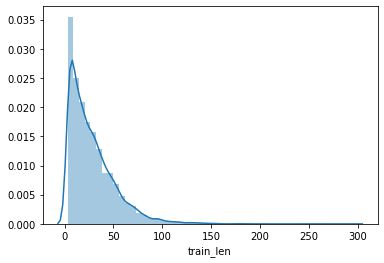

In [39]:
sns.distplot(d_transaction4.train_len)

### Data Loaders

In [40]:
args = Namespace(
    
    # Top Level
    mode='train',
    template=None,
    
    # Test
    test_model_path=None,
    
    # Dataset
    dataset_code='ml-1m',
    min_rating=4,
    min_uc=5,
    min_sc=0,
    split='leave_one_out',
    
    # Dataloader
    dataloader_code='bert',
    dataloader_random_seed=0.0,
    train_batch_size=64,
    val_batch_size=64,
    test_batch_size=64,
    
    # Negative Sampler
    train_negative_sampler_code='random',
    train_negative_sample_size=100,
    train_negative_sampling_seed=42,
    test_negative_sampler_code='random',
    test_negative_sample_size=100,
    test_negative_sampling_seed=42,
    
    # Trainer
    trainer_code='bert',
    device='cpu',
    num_gpu=1,
    device_idx='0',
    optimizer='Adam',
    lr=0.001,
    weight_decay=0,
    momentum=None,
    decay_step=15,
    gamma=0.1,
    num_epochs=100,
    log_period_as_iter=12800,
    metric_ks=[10], # [10, 20, 50]
    best_metric='NDCG@10',
    
    # Model
    model_code='bert',
    model_init_seed=42,
    bert_max_len=32,
    bert_num_items=len(product_ids),
    bert_hidden_units=32,
    bert_num_blocks=1,
    bert_num_heads=1,
    bert_dropout=0.0,
    bert_mask_prob=0.1,
    
    # Experiment
    experiment_dir='experiments',
    experiment_description='test'
)

In [41]:
train_seq = d_transaction4.train.to_dict()

In [42]:
val_seq = d_transaction4.val.to_dict()

In [43]:
test_seq = d_transaction4.test.to_dict()

In [44]:
negative_samples = d_transaction4.neg_sample.to_dict()

In [45]:
from utils import setup_train
from models import model_factory
from dataloaders.bert import BertTrainDataset, BertEvalDataset
from trainers import trainer_factory

In [46]:
export_root = setup_train(args)

Folder created: C:\Users\Andreas Chandra\Documents\PythonNotebook\recsys_ref\BERT4Rec-PyTorch\experiments\test_2021-08-24_0
{'bert_dropout': 0.0,
 'bert_hidden_units': 32,
 'bert_mask_prob': 0.1,
 'bert_max_len': 32,
 'bert_num_blocks': 1,
 'bert_num_heads': 1,
 'bert_num_items': 5543,
 'best_metric': 'NDCG@10',
 'dataloader_code': 'bert',
 'dataloader_random_seed': 0.0,
 'dataset_code': 'ml-1m',
 'decay_step': 15,
 'device': 'cpu',
 'device_idx': '0',
 'experiment_description': 'test',
 'experiment_dir': 'experiments',
 'gamma': 0.1,
 'log_period_as_iter': 12800,
 'lr': 0.001,
 'metric_ks': [10],
 'min_rating': 4,
 'min_sc': 0,
 'min_uc': 5,
 'mode': 'train',
 'model_code': 'bert',
 'model_init_seed': 42,
 'num_epochs': 100,
 'num_gpu': 1,
 'optimizer': 'Adam',
 'split': 'leave_one_out',
 'test_batch_size': 64,
 'test_negative_sample_size': 100,
 'test_negative_sampler_code': 'random',
 'test_negative_sampling_seed': 42,
 'train_batch_size': 64,
 'train_negative_sample_size': 100,
 't

In [47]:
model = model_factory(args)

In [48]:
rng = random.Random(args.dataloader_random_seed)

In [49]:
train_dataset = BertTrainDataset(train_seq, args.bert_max_len, args.bert_mask_prob, 
                                 len(product_ids)+1, len(product_ids), rng)
train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

In [50]:
val_dataset = BertEvalDataset(train_seq, val_seq, args.bert_max_len, len(product_ids)+1, negative_samples)
val_loader = DataLoader(val_dataset, batch_size=args.val_batch_size, shuffle=True)

In [51]:
test_dataset = BertEvalDataset(train_seq, test_seq, args.bert_max_len, len(product_ids)+1, negative_samples)
test_loader = DataLoader(test_dataset, batch_size=args.val_batch_size, shuffle=True)

In [52]:
batch = next(iter(val_loader))

In [53]:
seq, candidates, labels = batch

In [54]:
labels

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

In [55]:
trainer = trainer_factory(
        args, model, train_loader, val_loader, test_loader, export_root)

In [56]:
trainer.train()

  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 0


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 0


Epoch 3, loss 7.383 :   0%|                                                          | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 1


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 2


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 3


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 4


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 5


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 6


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 7


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 8


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 9


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 10


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 11


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 12


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 13


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 14


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 15


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 16


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 17


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 18


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 19


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 20


Epoch 23, loss 4.887 :   0%|                                                         | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 21


Epoch 24, loss 5.110 :   0%|                                                         | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 22


  0%|                                                                                | 0/247 [00:00<?, ?it/s]

Update Best NDCG@10 Model at 24


Epoch 27, loss 5.005 :   1%|▍                                                | 2/247 [00:00<00:59,  4.10it/s]


KeyboardInterrupt: 